In [1]:
from IPython.core.display import HTML
styles = open( '../styles/custom.css', 'r' ).read()
HTML( styles )

In [2]:
from sklearn.datasets import load_iris
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting style defaults
import seaborn as sns; sns.set()

In [3]:
iris = load_iris()

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

In [6]:
X = iris.data
y = iris.target

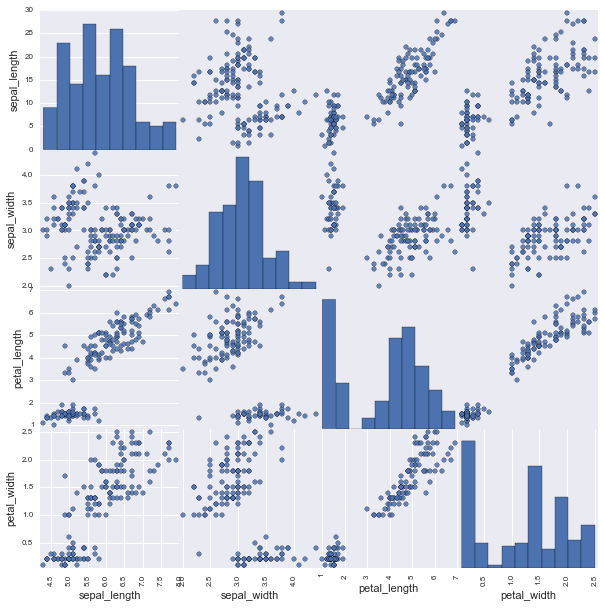

In [7]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
df = pd.DataFrame( X, columns=[ 'sepal_length', 'sepal_width', 'petal_length', 'petal_width' ])
_ = scatter_matrix(df, alpha=0.85, figsize=(10, 10), diagonal='hist', grid = True, marker = 'o' )

In [8]:
# scatter_matrix?

In [9]:
# decision tree와 feature names을 받아, if~ else 형태의 pseudo-code를 인쇄한다
def get_code( tree, feature_names ) :
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [ feature_names[i] for i in tree.tree_.feature ]
    value = tree.tree_.value

    f = open( 'decision_tree.output', 'w' )
    
    def recurse( left, right, threshold, features, node, f ):
        if threshold[ node ] != -2 :
            print( "if ( " + features[ node ] + " <= " + str( threshold[ node ] ) + " ) {" )
            f.write( "if ( " + features[ node ] + " <= " + str( threshold[ node ] ) + " ) {\n" )
            if left[ node ] != -1:
                recurse( left, right, threshold, features,left[ node ], f )
            print( "} else {" )
            f.write( "} else {\n" )
            if right[ node ] != -1:
                recurse( left, right, threshold, features,right[ node ], f )
            print( "}" )
            f.write( "}\n" )
        else:
            print( "return " + str( value[ node ] ) )
            f.write( "return " + str( value[ node ] ) + '\n' )
    
    recurse( left, right, threshold, features, 0, f )
    
    f.close()

In [10]:
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
_ = plt.gray()

In [11]:
from sklearn.grid_search import ParameterGrid

In [12]:
def compute_evaluation( cv_split_filename, model, params ):
    """Function executed by a worker to evaluate a model on a CV split"""
    # All module imports should be executed in the worker namespace
    from sklearn.externals import joblib

    X_train, y_train, X_validation, y_validation = joblib.load( cv_split_filename, mmap_mode='c' )
    
    model.set_params( **params )
    model.fit( X_train, y_train )
    validation_score = model.score( X_validation, y_validation )
    return validation_score

In [13]:
def grid_search( lb_view, model, cv_split_filenames, param_grid ):
    """Launch all grid search evaluation tasks."""
    all_tasks = []
    all_parameters = list( ParameterGrid( param_grid ) )
    
    for i, params in enumerate( all_parameters ):
        task_for_params = []
        
        for j, cv_split_filename in enumerate( cv_split_filenames ):
            t = lb_view.apply( compute_evaluation, cv_split_filename, model, params )
            task_for_params.append( t ) 
        
        all_tasks.append( task_for_params )
        
    return all_parameters, all_tasks

In [14]:
from sklearn.externals import joblib
from sklearn.cross_validation import ShuffleSplit
import os

def persist_cv_splits( X, y, n_cv_iter = 5, name='data', suffix="_cv_%03d.pkl", test_size=0.25, random_state=None ):
    """Materialize randomized train test splits of a dataset."""

    cv = ShuffleSplit(X.shape[0], n_iter=n_cv_iter,test_size=test_size, random_state=random_state)
    cv_split_filenames = []
    
    for i, (train, test) in enumerate(cv):
        cv_fold = (X[train], y[train], X[test], y[test])
        cv_split_filename = name + suffix % i
        cv_split_filename = os.path.abspath(cv_split_filename)
        joblib.dump(cv_fold, cv_split_filename)
        cv_split_filenames.append(cv_split_filename)
    
    return cv_split_filenames

In [15]:
iris_split_filenames = persist_cv_splits( X, y, name = 'iris', random_state = 0 )
iris_split_filenames

['E:\\88.analytics\\15.09.22.01.tech.fair\\iris_cv_000.pkl',
 'E:\\88.analytics\\15.09.22.01.tech.fair\\iris_cv_001.pkl',
 'E:\\88.analytics\\15.09.22.01.tech.fair\\iris_cv_002.pkl',
 'E:\\88.analytics\\15.09.22.01.tech.fair\\iris_cv_003.pkl',
 'E:\\88.analytics\\15.09.22.01.tech.fair\\iris_cv_004.pkl']

In [16]:
from IPython.parallel import Client

client = Client()
lb_view = client.load_balanced_view()

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
params = {
           'criterion' : ( 'gini', 'entropy' ),
           'splitter' : ( 'best', 'random' ),
           'max_features' : ( 'auto', 'sqrt', 'log2', None ),
           'max_depth' : ( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, None ),
}

all_parameters, all_tasks = grid_search( lb_view, clf, iris_split_filenames, params )

In [18]:
def progress( tasks ):
    return np.mean( [ task.ready() for task_group in tasks
                                 for task in task_group ] )

In [19]:
def find_bests( all_parameters, all_tasks, n_top = 5 ) :
    """Compute the mean score of the completed tasks"""
    mean_scores = []
    
    for param, task_group in zip(all_parameters, all_tasks):
        scores = [t.get() for t in task_group if t.ready()]
        if len(scores) == 0:
            continue
        mean_scores.append((np.mean(scores), param))
                   
    return sorted(mean_scores, reverse=True, key=lambda x: x[0])[:n_top]

In [20]:
from pprint import pprint

# print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
# pprint(find_bests(all_parameters, all_tasks))

In [21]:
%%time
[ t.wait() for tasks in all_tasks for t in tasks ]
print("Tasks completed: {0}%".format(100 * progress(all_tasks)))
pprint(find_bests(all_parameters, all_tasks))

Tasks completed: 100.0%
[(0.9631578947368421,
  {'criterion': 'gini',
   'max_depth': 12,
   'max_features': None,
   'splitter': 'random'}),
 (0.9631578947368421,
  {'criterion': 'entropy',
   'max_depth': 10,
   'max_features': None,
   'splitter': 'random'}),
 (0.95789473684210535,
  {'criterion': 'gini',
   'max_depth': 4,
   'max_features': 'auto',
   'splitter': 'best'}),
 (0.95789473684210535,
  {'criterion': 'gini',
   'max_depth': 9,
   'max_features': None,
   'splitter': 'random'}),
 (0.95789473684210535,
  {'criterion': 'gini',
   'max_depth': 10,
   'max_features': None,
   'splitter': 'random'})]
Wall time: 2.23 s


In [ ]:
import sys, imp
from collections import OrderedDict
sys.path.append('..')
# imp?
import model_selection, mmap_utils
imp.reload( model_selection ), imp.reload( mmap_utils )

lb_view.abort()

params = OrderedDict( [
                        ( 'criterion', ( 'gini', 'entropy' ) ),
                        ( 'splitter', ( 'best', 'random' ) ),
                        ( 'max_features', ( 'auto', 'sqrt', 'log2', None ) ),
                        ( 'max_depth', ( 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, None ) ),
] )

search = model_selection.RandomizedGridSeach( lb_view )
search.launch_for_splits( clf, params, iris_split_filenames )

In [ ]:
print(search.report())

In [ ]:
plt.rcParams['figure.figsize'] = 12, 30
plt.rcParams['axes.grid'] = True
_ = plt.gray()

In [ ]:
print(search.report())
search.boxplot_parameters(display_train=False)
search.boxplot_parameters?
search.find_bests

In [ ]:
# clf.fit( X, y )

# get_code( clf, iris.feature_names )

In [ ]:
# from sklearn.tree import export_graphviz
# from sklearn import tree
# import subprocess

# def visualize_tree( clf, p_feature_names ) :
#     dot_file = 'iris.dot'
#     png_file = 'iris.png'
#     tree.export_graphviz( clf, out_file = dot_file, feature_names = p_feature_names )
#     command = [ 'dot', '-Tpng', dot_file, '-o', png_file ]

#     try :
#         subprocess.check_call( command )
#     except :
#         print( 'exception' )

In [ ]:
# visualize_tree( clf, iris.feature_names )

<img src='iris.png' width = "100%"/>